In [152]:
from drn_interactions.interactions.loaders import SpontaneousActivityLoader, StateInteractionsLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.interactions.graph_clustering import df_to_graph
from drn_interactions.plots.heatmaps import state_indicator
from drn_interactions.decoding.loaders import StateDecodeDataLoader
from drn_interactions.decoding.preprocessors import StateDecodePreprocessor
from drn_interactions.config import ExperimentInfo
from drn_interactions.io import load_derived_generic, load_distances
from drn_interactions.transforms.graph import GraphTransformer
from drn_interactions.transforms.spikes import SpikesHandler
from sklearn.preprocessing import minmax_scale, robust_scale
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.ndimage import gaussian_filter1d, median_filter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Sequence
from sklearn.preprocessing import LabelEncoder




In [196]:
# sns.set_theme(style="ticks", context="paper")


In [216]:
# Example Heats


class Loaders:
    def __init__(
        self,
        session_name,
        bin_width=1,
        t_start=0,
        t_stop=1800,
        gaussian_sigma=None,
        df_ensembles=None,
        ensemble_id_col: str = "ensemble_id",
        ensemble_labels=None,
        ensemble_ref_state: str = "sw",
        corr_fill_value=0,
        states_medfilt=5,
        rev_order_spikes=True
    ):
        self.session_name = session_name
        self.bin_width = bin_width
        self.t_start = t_start
        self.t_stop = t_stop
        self.gaussian_sigma = gaussian_sigma
        self.corr_fill_value = corr_fill_value
        self.states_medfilt = states_medfilt
        self.rev_order_spikes = rev_order_spikes
        if df_ensembles is not None:
            self.labels = df_ensembles.loc[lambda x: (x.session_name == session_name) & (x.state == ensemble_ref_state)]
            self.labels = self.labels.sort_values("neuron_id")[ensemble_id_col].values
        else:
            self.labels = None

    def reorder_affinity(self, df_affinity: pd.DataFrame) -> pd.DataFrame:
        idx = np.argsort(self.labels)
        return df_affinity.iloc[idx, idx].fillna(self.corr_fill_value)

    def reorder_spikes(self, spikes: pd.DataFrame) -> pd.DataFrame:
        idx = np.argsort(self.labels)
        return spikes.iloc[idx, :]

    def get_affinity(self, spikes: pd.DataFrame) -> pd.DataFrame:
        preprocessor = InteractionsPreprocessor(z=True)
        mod = PairwiseCorr(rectify=True)
        spikes = preprocessor(spikes)
        df_affinity = mod.fit(spikes).get_adjacency_df()
        if self.labels is not None:
            return self.reorder_affinity(df_affinity)
        return df_affinity

    def preprocess_spikes(self, spikes: pd.DataFrame) -> pd.DataFrame:
        if self.gaussian_sigma is not None:
            spikes = spikes.transform(gaussian_filter1d, sigma=self.gaussian_sigma)
        vals = TfidfTransformer().fit_transform(spikes).todense()
        spikes = (
            pd.DataFrame(vals, columns=spikes.columns, index=spikes.index)
            .apply(minmax_scale)
            .T
        )
        return spikes

    def get_states(self) -> pd.Series:
        loader = StateDecodeDataLoader(
            session_name=self.session_name,
            t_start=self.t_start,
            t_stop=self.t_stop,
            bin_width=self.bin_width,
        )
        preprocessor = StateDecodePreprocessor()
        spikes, states = loader()
        spikes, states = preprocessor(spikes, states)
        if self.states_medfilt is not None:
            le = LabelEncoder()
            state_vals = le.fit_transform(states.values)
            state_vals = median_filter(state_vals, size=self.states_medfilt)
            state_vals = le.inverse_transform(state_vals)
            states = pd.Series(state_vals, index=states.index)
        return states

    def get_spikes_alltime(self, preprocess: bool = True) -> pd.DataFrame:
        loader = StateDecodeDataLoader(
            session_name=self.session_name,
            t_start=self.t_start,
            t_stop=self.t_stop,
            bin_width=self.bin_width,
        )
        preprocessor = StateDecodePreprocessor()
        spikes, states = loader()
        spikes, _ = preprocessor(spikes, states)
        if preprocess:
            spikes = self.preprocess_spikes(spikes)
        if self.labels is not None:
            spikes = self.reorder_spikes(spikes)
        if self.rev_order_spikes:
            spikes = spikes.iloc[::-1, :]
        return spikes

    def get_spikes_single_state(
        self, state: str, preprocess: bool = True
    ) -> pd.DataFrame:
        loader = StateInteractionsLoader(
            session_name=self.session_name,
            t_start=self.t_start,
            t_stop=self.t_stop,
            bin_width=self.bin_width,
            state=state,
        )
        spikes = loader()
        if preprocess:
            spikes = self.preprocess_spikes(spikes)
        if self.labels is not None:
            spikes = self.reorder_spikes(spikes)
        if self.rev_order_spikes:
            spikes = spikes.iloc[::-1, :]
        return spikes

    def get_affinity_alltime(self, preprocess=False) -> pd.DataFrame:
        spikes = self.get_spikes_alltime(preprocess=preprocess)
        df_affinity = self.get_affinity(spikes)
        return df_affinity

    def get_affinity_single_state(self, state, preprocess=False):
        spikes = self.get_spikes_single_state(preprocess=preprocess, state=state)
        df_affinity = self.get_affinity(spikes)
        return df_affinity

class Plotter:

    def __init__(self, corr_cmap="viridis", corr_vmin=0, corr_vmax=1, spikes_cmap="Greys", spikes_vmin=0, spikes_vmax=1):
        self.corr_cmap = corr_cmap
        self.corr_vmin = corr_vmin
        self.corr_vmax = corr_vmax
        self.spikes_cmap = spikes_cmap
        self.spikes_vmin = spikes_vmin
        self.spikes_vmax = spikes_vmax
    
    def plot_affinity(self, df_affinity: pd.DataFrame, ax: plt.Axes, **kwargs):
        sns.heatmap(
            df_affinity, cmap=self.corr_cmap, ax=ax, vmin=self.corr_vmin, vmax=self.corr_vmax, **kwargs
        )
        return ax 
    
    def plot_spikes(self, spikes: pd.DataFrame, ax: plt.Axes, **kwargs):
        sns.heatmap(spikes, cmap=self.spikes_cmap, vmin=self.spikes_vmin, vmax=self.spikes_vmax, ax=ax, **kwargs)
        return ax
    
    def plot_states(self, states: pd.Series, ax: plt.Axes, order: Sequence[str] = ("sw", "act"),  **kwargs):
        state_indicator(states=states, order=order, ax=ax, **kwargs)
        return ax

In [217]:
spikes

bin,1798,1797,1796,1795,1794,1793,1792,1791,1790,1789,...,9,8,7,6,5,4,3,2,1,0
2629,0.245740,0.245455,0.242047,0.121086,0.118859,0.118809,0.000000,0.000000,0.000000,0.119664,...,0.100764,0.098919,0.098784,0.098353,0.098608,0.099174,0.097995,0.000000,0.000000,0.000000
2595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.105152,0.103226,0.103086,0.102636,0.102902,0.103492,0.102262,0.100564,0.097505,0.192326
2627,1.000000,0.665894,0.656648,0.328494,0.000000,0.000000,0.000000,0.000000,0.000000,0.324636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2626,0.139114,0.138952,0.137023,0.000000,0.000000,0.000000,0.000000,0.000000,0.136092,0.135484,...,0.456342,0.447985,0.447375,0.445421,0.446578,0.449139,0.443799,0.436432,0.423156,0.417332
2601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.100107,0.099670,0.099929,0.100502,0.099307,0.097658,0.094687,0.093384
2603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.474545,0.465854,0.465221,0.617584,0.619188,0.622739,0.769170,0.756401,0.733391,0.723297
2604,0.516900,0.515960,0.504720,0.505134,0.490445,0.686043,0.682933,0.696620,0.697528,0.693095,...,0.869603,0.848300,0.846747,0.841764,0.682095,0.687690,0.676024,0.501003,0.476830,0.466227
2605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.290710,0.285386,0.284998,0.283753,0.426735,0.429182,0.565440,0.556053,0.539138,0.531717
2609,0.596482,0.595790,0.587518,0.542605,0.532627,0.532400,0.530710,0.538148,0.538641,0.536232,...,0.827824,0.849603,0.848446,0.844739,0.846934,0.851790,0.878259,0.899666,0.907189,0.929115
2612,0.255219,0.254923,0.251383,0.251514,0.246888,0.246783,0.246000,0.249448,0.249676,0.248560,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


[Text(0, 0, '0'), Text(600, 0, '10'), Text(1200, 0, '20'), Text(1800, 0, '30')]

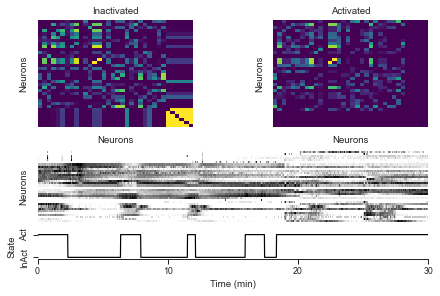

In [221]:
df_ensembles = load_derived_generic("ensembles/bs - ensembles.csv").drop_duplicates()
sessions = df_ensembles.session_name.unique()


loader = Loaders(session_name=sessions[14], df_ensembles=df_ensembles, gaussian_sigma=2, states_medfilt=60)
plotter = Plotter()

spikes = loader.get_spikes_alltime(preprocess=True)
states = loader.get_states()
df_affinity_sw = loader.get_affinity_single_state(preprocess=False, state="sw")
df_affinity_act = loader.get_affinity_single_state(preprocess=False, state="act")


f = plt.figure(figsize=(6, 4), constrained_layout=True)
axes = f.subplot_mosaic(
    [["A", "B"], ["C", "C"], ["S", "S"]], 
    gridspec_kw=dict(height_ratios=[1.5, 1, 0.35], width_ratios=[1, 1], wspace=0.095),
    )

plotter.plot_affinity(df_affinity_sw, axes["A"], cbar=False, xticklabels=[], yticklabels=[])
plotter.plot_affinity(df_affinity_act, axes["B"], cbar=False, xticklabels=[], yticklabels=[])
plotter.plot_spikes(spikes, axes["C"], cbar=False, xticklabels=[], yticklabels=[])
plotter.plot_states(states, axes["S"])


axes["A"].set_title("Inactivated")
axes["A"].set_xlabel("Neurons")
axes["A"].set_ylabel("Neurons")

axes["B"].set_title("Activated")
axes["B"].set_xlabel("Neurons")
axes["B"].set_ylabel("Neurons")

axes["C"].set_xlabel("")
axes["C"].set_ylabel("Neurons")

axes["S"].set_ylabel("State")
axes["S"].set_xlabel("Time (min)")
axes["S"].set_yticklabels(["InAct", "Act"], rotation=90, va="center")
axes["S"].set_xticks(np.arange(0, 1810, 600))
axes["S"].set_xticklabels(np.arange(0, 1810, 600)//60)
